# Intermediate Algorithms & Applications
- Before you start: run this single imports/setup cell once at the top of the notebook section.

In [2]:
# Run this once
import numpy as np
from math import pi
from fractions import Fraction
from collections import Counter

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, RZZGate


# Optimizer
from qiskit_algorithms.optimizers import COBYLA

# simulator
sim = AerSimulator()

# helper: run circuit and return counts
def run_counts(qc, shots=2000):
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    return job.result().get_counts()


# Quantum Fourier Transform (QFT)

- Goal (plain): QFT is the quantum analogue of the discrete Fourier transform. It maps computational basis amplitudes to a frequency-like basis; it’s vital for many algorithms (e.g., Shor, Phase Estimation).

- What you’ll do

- Build a reusable QFT circuit (library QFT is fine for correctness, but I’ll also show a short manual construction to learn the steps).

- Apply QFT to simple basis states and compare with classical DFT of the basis vector.

Manual QFT circuit (3 qubits):


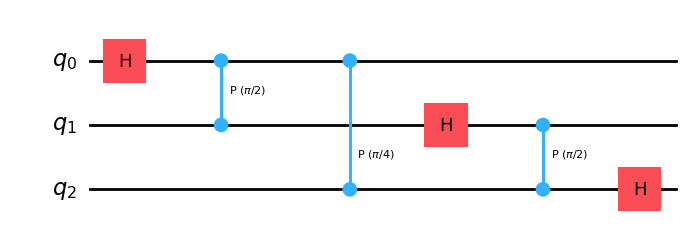

Library QFT circuit (3 qubits):


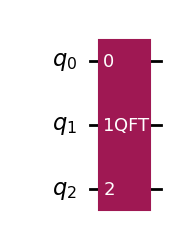

Measurement (after QFT) counts: {'010': 265, '100': 256, '110': 232, '011': 256, '001': 260, '111': 217, '000': 263, '101': 251}


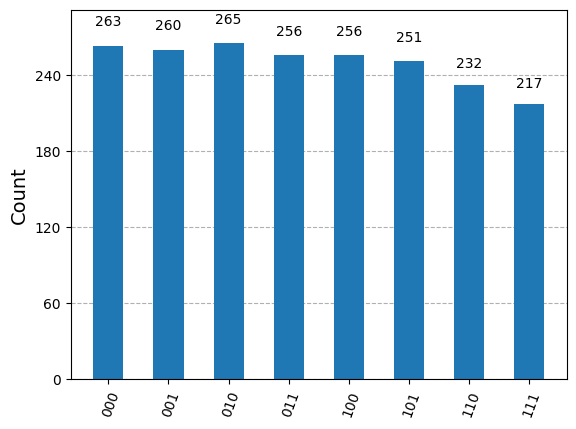

In [6]:
# Manual QFT Implementation
import numpy as np
def qft_manual(n):
    qc = QuantumCircuit(n)
    for j in range(n):
        qc.h(j)
        # controlled phase rotations with increasing small angles
        for k in range(1,n-j):
            angle = np.pi/ (2**k) # pi/2^k
            qc.cp(angle, j+k, j) ## control = j+k, target = j (this ordering implements phase correctly)
             # Note: many textbooks swap at the end to reverse order; use swaps if you want bit-reversal
    return qc
# QFT on 3 qubits (manual)
qc_qft_manual = qft_manual(3)
print("Manual QFT circuit (3 qubits):")
display(qc_qft_manual.draw('mpl'))

# Use QFT library 
qc_qft_lib = QFT(3, do_swaps=True)   # do_swaps=True will reverse qubit order at end
print("Library QFT circuit (3 qubits):")
display(qc_qft_lib.draw('mpl'))

# Test QFT on basis states ket 1 and compare classical DFT
# Prepare ket 001 
qc = QuantumCircuit(3)
qc.x(0)  
qc.append(QFT(3, do_swaps= True).to_instruction(),range(3))
qc.measure_all()
counts = run_counts(qc, shots = 2000)
print("Measurement (after QFT) counts:", counts)
plot_histogram(counts)


# Quantum Phase Estimation (QPE)

- Goal (plain): Given a unitary U and an eigenstate ∣ψ⟩ with eigenvalue 
- e^2πiϕ, estimate 𝜙. QPE is the quantum way to read off phases (used in many algorithms).

- Simple, robust example (beginners)
- We pick a simple unitary that's diagonal: a phase gate 𝑈=Phase(2*pi*phi) = diag(1, e^2*pi*i*phi)
- If target = ket 1 it's an eigenstate with eigenvalue e^2*pi*i*phi. QPE estimates phi.

QPE counts (top): [('10000', 2024), ('00000', 1976)]


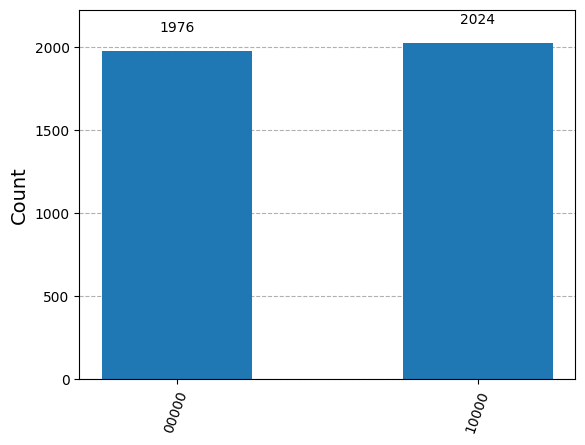

In [21]:
# QPE for a phase gate unitary
from qiskit.circuit.library import PhaseGate

def qpe_phase(phi, n_count=4, shots = 4096):
     """
    QPE estimating phase phi (0<=phi<1) of unitary U = diag(1, e^{2π i phi}).
    n_count: number of counting qubits (precision).
    """
     qc =QuantumCircuit(n_count +1 , n_count)
     # prepare target in eigenstate |1> (the eigenvector that picks up phase e^{2π i phi})
     qc.x(n_count)
     qc.h(range(n_count))

     for j in range(n_count):
          angle = 2 *np.pi * phi * (2**j)
          qc.cp(angle, j, n_count)

          # Inverse QFT o counting register
          qc.append(QFT(n_count, do_swaps=True).inverse().to_instruction(), range(n_count))
          qc.measure(range(n_count), range(n_count))
          counts = run_counts(qc, shots=shots)
          return qc, counts
# Example: phi = 0.25 (i.e., eigenphase = 1/4)
qc_used, counts = qpe_phase(0.25, n_count=5, shots=4000)
print("QPE counts (top):", sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:8])
plot_histogram(counts)     

# QAOA — Intro & hands-on MaxCut example (small graph)
- Goal (plain): QAOA is a variational algorithm for combinatorial optimization. You prepare a parameterized quantum state by alternating cost and mixer unitaries; a classical optimizer tunes parameters to maximize the expected cost (here MaxCut).

Plan for beginners

Choose a tiny graph (2 or 3 nodes).

Build QAOA layer(s) manually: start with H on all qubits, then for each layer apply cost unitaries (RZZ for each edge) and mixer unitaries (Rx on each qubit).

Evaluate expected cut value by sampling and computing classical cost from bitstrings.

Use a classical optimizer (COBYLA) to find best parameters.


Best params (gamma,beta): [1.25986937 0.33391074]
Best expected cut (estimated): 1.9969999999999999
Counts with best params: {'010': 663, '100': 648, '101': 694, '001': 662, '011': 626, '110': 693, '000': 9, '111': 5}


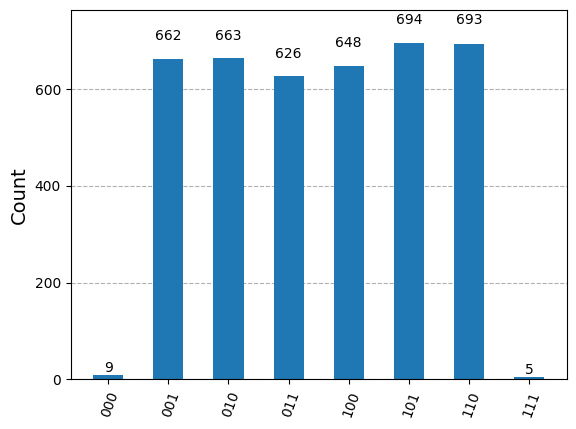

In [30]:
# QAOA for Maxcut on a tiny graph
import itertools 
import networkx as nx

# Define graph
G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,0)])
n = len(G.nodes())

# Classical cost: Given bitstring, compute cut value for graph G (Unweighted)

def cut_value(bitstr, G):
    val = 0
    for i,j in G.edges():
        if bitstr[-1-i] != bitstr[-1-j]:
            val += 1
    return val

# Build QAOA Circuit for one layer (p=1)
def qaoa_circuit(gamma, beta, G):
    n = len(G.nodes())
    qc = QuantumCircuit(n)
# Put in uniform superposition
    qc.h(range(n))
# Cost unitary : for each edge apply RZZ(2*gamma)
    for (i,j) in G.edges():
        qc.append(RZZGate(2*gamma), [i,j])
    # Mixer : Rx(2*beta) on each qubit
    for q in range(n):
        qc.rx(2*beta, q)
    return qc

# Expectation evaluation by sampling
def qaoa_expectations(params, G, shots = 4000):
    gamma, beta = params
    qc = qaoa_circuit(gamma, beta, G)
    qc.measure_all()
    counts = run_counts(qc, shots=shots)
    # compute expected cut value
    exp = 0
    total = sum(counts.values())
    for bitstr, count in counts.items():
        val = cut_value(bitstr, G)
        exp += val * count / total
    return exp

# Wrapper objectives for optimizer
def objective_x(params):
    val = qaoa_expectations(params, G, shots=2000)
    return -val  # minimize negative of expectation  

# Initial Guess
init= [0.5,0.5]
optimizer = COBYLA(maxiter=80)
res = optimizer.minimize(fun=objective_x, x0=init)

best_params = res.x
best_val = -res.fun
print("Best params (gamma,beta):", best_params)
print("Best expected cut (estimated):", best_val)

# Show distribution with best params
gamma_opt, beta_opt = best_params
qc_opt = qaoa_circuit(gamma_opt, beta_opt, G)
qc_opt.measure_all()
counts_opt = run_counts(qc_opt, shots=4000)
print("Counts with best params:", counts_opt)
plot_histogram(counts_opt)


 Variational Quantum Eigensolver (VQE) — a simple 2-qubit example

Goal (plain): VQE finds the minimal eigenvalue (ground state energy) of a Hamiltonian H by preparing a parameterized state |ψ(θ)⟩ and minimizing the expectation value ⟨H⟩.

For beginners we’ll:
- Use a small 2-qubit Hamiltonian that mixes ZZ and XX terms:

  H = c₁(Z₀Z₁) + c₂(X₀X₁)

  This keeps measurement & code simple (you will measure in Z and X bases only).
- Use a small ansatz (two layers of Ry + CNOT entangler).
- Use COBYLA to optimize the parameters by sampling.

In [8]:
# Simple VQE for H= c1 * Z0 Z1 + c2 * X0 X1
c1, c2 = 1.0,1.0

# Prepare Ansatz circuit for given theta vector (length 4)
def ansatz_circuit(theta):
    """
    thetas: array-like of 4 parameters
    Circuit:
      Ry(theta0) --●-- Ry(theta2)
      Ry(theta1) --X-- Ry(theta3)
    where we entangle with CNOT(0,1)
    """
    qc = QuantumCircuit(2)
    qc.ry(theta[0],0)
    qc.ry(theta[1],1)
    qc.cx(0,1)
    qc.ry(theta[2],0)
    qc.ry(theta[3],1)
    return qc

# Expectation of Z0 Z1
def expect_zz (theta, shots=4000):
    qc = ansatz_circuit(theta)
    qc.measure_all()
    counts = run_counts(qc, shots=shots)
    total =sum(counts.values())
    exp=0.0
    for bitstr,count in counts.items():
        b0=int(bitstr[-1])
        b1=int(bitstr[-2])
        z0 = 1 if b0==0 else -1
        z1 = 1 if b1==0 else -1
        exp += z0 * z1 * count / total
    return exp

# Expectation value of X0 X1
def expect_xx (theta, shots=4000):
    qc = ansatz_circuit(theta)
    qc.measure_all()
    counts = run_counts(qc, shots=shots)
    total =sum(counts.values())
    exp=0.0
    for bitstr,count in counts.items():
        b0=int(bitstr[-1])
        b1=int(bitstr[-2])
        x0 = 1 if b0==1 else -1
        x1 = 1 if b1==1 else -1
        exp += x0 * x1 * count / total
    return exp

# Total Energy expectation
def energy(theta):
    ezz = expect_zz(theta, shots=2000)
    exx = expect_xx(theta, shots=2000)
    return c1 * ezz + c2 * exx

# Objective for optimizer (minimize energy)
def vqe_objective(x):
    return energy(x)

# Initial Parameters
init = np.random.random(4)*(0.1)
optimizer = COBYLA(maxiter=120)
result = optimizer.minimize(fun=vqe_objective, x0=init)
theta_opt = result.x
min_energy = result.fun
print('Optimized Parameters:', theta_opt)
print('Minimum Energy:', min_energy)

Optimized Parameters: [-0.77163849  0.79756611  0.63452305  2.19143896]
Minimum Energy: -1.9980000000000002


Hands-on: Small Optimization Problem with QAOA

In this example, we will use the Quantum Approximate Optimization Algorithm (QAOA) to solve a small MaxCut problem.

Step 1: What is MaxCut?

The MaxCut problem: Given a graph, divide its nodes into two groups such that the number of edges between the groups is maximized.

Example: If two nodes are connected, we want to put them in different groups.

This is a classic combinatorial optimization problem that QAOA can solve.